In [69]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm

from graspy.embed import JointRDPG
from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.cluster import GaussianCluster, KMeansCluster
from graspy.simulations import sbm

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import sbm_marg_corr_diff, ER_corr
from utils import sbm_params, triu_no_diag, to_distance_mtx, identity, power, non_diagonal, \
    estimate_block_assignment

In [3]:
A = np.arange(1, 10).reshape(3, 3)
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [29]:
def rho_sbm_diff_block(rho, k, AL, BL, n=100):
    if sum(k) != n:
        raise ValueError('the total number of vertices in each community should equal n')
    
    if np.any(AL == 0) or np.any(AL == 1) \
            or np.any(BL == 0) or np.any(BL == 1):
        raise ValueError('block probabilities AL and BL cannot have 0 or 1')

    largest_rho = np.minimum(np.sqrt(AL*(1-BL)/((1-AL)*BL)), np.sqrt((1-AL)*BL/(AL*(1-BL))))
    if np.any(rho > largest_rho):
        raise ValueError('the largest valid rho for the specified AL and BL is {}. Please specify a rho that is smaller than the largest valid rho.'.format(
            np.amin(largest_rho)))

    AL = symmetrize(AL)
    BL = symmetrize(BL)
    A = sbm(k, AL)

    AL_new = np.zeros_like(A)
    BL_new = np.zeros_like(A)
    block_indices = np.insert(np.cumsum(np.array(k)), 0, 0)
    for i in range(AL.shape[0]):
        for j in range(AL.shape[1]):
            AL_new[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]] = AL[i, j]
            BL_new[block_indices[i]:block_indices[i+1], block_indices[j]:block_indices[j+1]] = BL[i, j]

    prob = BL_new + A*rho*np.sqrt((1-AL_new)*BL_new*(1-BL_new)/AL_new) - (1-A)*rho*np.sqrt(AL_new*BL_new*(1-BL_new)/(1-AL_new))
    B = np.random.binomial(1, prob)
    B = B.astype(np.float64)
    B = symmetrize(B)
    np.fill_diagonal(B, 0)
    return A, B

In [26]:
def permute_off_diag(A):
    return np.random.permutation(A.flatten()).reshape(A.shape)

def permute_on_diag(A):
    triu = np.random.permutation(triu_no_diag(A).flatten())
    A_perm = np.zeros_like(A)
    A_perm[np.triu_indices(A.shape[0], 1)] = triu
    A_perm = symmetrize(A_perm)
    return A_perm

In [78]:
def block_permute(A, block_assignment):
    permuted_A = np.zeros_like(A)
    num_blocks = np.unique(block_assignment).size
    # get the index of the blocks in the upper triangular
    row_idx, col_idx = np.triu_indices(num_blocks)
    for t in range(row_idx.size):
        i = row_idx[t]
        j = col_idx[t]
        block_i_idx = np.where(block_assignment == i)[0]
        block_j_idx = np.where(block_assignment == j)[0]
        block = A[np.ix_(block_i_idx, block_j_idx)]
        # permute only the upper triangular if the block is on the diagonal
        if i == j:
            permuted_block = permute_on_diag(block)
        else:
            permuted_block = permute_off_diag(block)
        permuted_A[np.ix_(block_i_idx, block_j_idx)] = permuted_block
    permuted_A = symmetrize(permuted_A)
    return permuted_A

In [106]:
A, B = rho_sbm_diff_block(0.3, k=[70, 30], AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.7, b=0.3), n=100)

In [107]:
block_assignment = estimate_block_assignment(A, B)

In [108]:
block_assignment

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [88]:
def _sort_inds(inner_labels, outer_labels):
    sort_df = pd.DataFrame(columns=("inner_labels", "outer_labels"))
    sort_df["inner_labels"] = inner_labels
    if outer_labels is not None:
        sort_df["outer_labels"] = outer_labels
        sort_df.sort_values(
            by=["outer_labels", "inner_labels"], kind="mergesort", inplace=True
        )
        outer_labels = sort_df["outer_labels"]
    inner_labels = sort_df["inner_labels"]
    sorted_inds = sort_df.index.values
    return sorted_inds

def sort_graph(graph, inner_labels):
    inds = _sort_inds(inner_labels, np.ones_like(inner_labels))
    graph = graph[inds, :][:, inds]
    return graph

In [109]:
A_sorted = sort_graph(A, block_assignment)

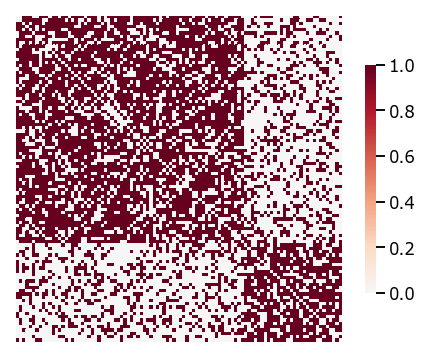

In [110]:
heatmap(A, figsize=(8, 6))

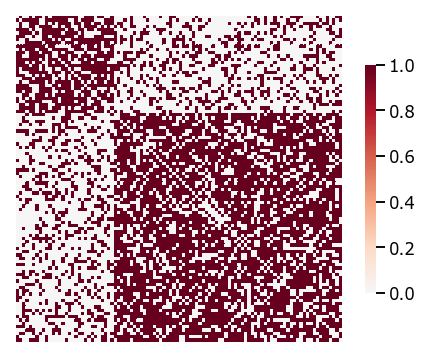

In [111]:
heatmap(A_sorted, figsize=(8, 6))

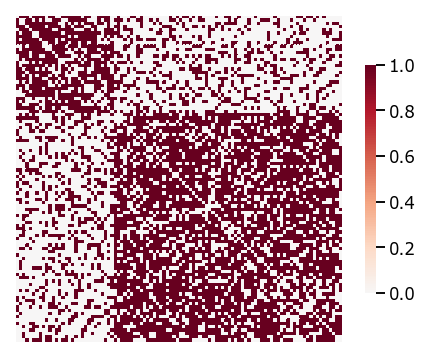

In [112]:
heatmap(block_permute(A_sorted, np.sort(block_assignment)), figsize=(8, 6))

In [113]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k, n, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_diff_block(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B)
        A = sort_graph(A, block_assignment)
        B = sort_graph(B, block_assignment)
        A_null = block_permute(A, np.sort(block_assignment))
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [115]:
%%time
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
P1 = sbm_params(a=0.7, b=0.3)
P2 = sbm_params(a=0.2, b=0.5)
test_names = ['pearson', 'dcorr'] #['pearson', 'dcorr', 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            k = [int(0.7*n), n-int(0.7*n)]
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100
finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n

In [116]:
power_sbm

{'pearson': array([[0.114, 0.212, 0.068, 0.076, 0.062, 0.044, 0.06 , 0.042, 0.05 ,
         0.06 ],
        [0.046, 0.032, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   ]]),
 'dcorr': array([[0.006, 0.004, 0.   , 0.018, 0.062, 0.032, 0.032, 0.052, 0.042,
         0.058],
        [0.05 , 0.034, 0.104, 0.548, 0.94 , 0.988, 0.996, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}